# HW3

Лучше ничего не перезапускать. Возможно, только до Data Preprocessing перезапустить стоит (если не показываются графики).

In [122]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [123]:
target = pd.read_csv('target.csv')#1
ticker = pd.read_csv('ticker.csv.gz')#2
book = pd.read_csv('book.csv.gz')#3
trades = pd.read_csv('trades.csv.gz')#4

*Threshold*

In [124]:
# Будем брать каждое 10 значение в датафрейме
book = book.iloc[::10, :]
trades = trades.iloc[::10, :]
ticker = ticker.iloc[::10, :]
target = target.iloc[::10, :]

In [125]:
book = book.reset_index(drop=True)
trades = trades.reset_index(drop=True)
ticker = ticker.reset_index(drop=True)
target = target.reset_index(drop=True)

In [126]:
#threshold = '2023-03-22 23:59:59'
threshold = '2023-03-24 23:59:59'

In [127]:
book['local_timestamp'] = pd.to_datetime(book['local_timestamp'])
trades['local_ts'] = pd.to_datetime(trades['local_ts'])
ticker['local_ts'] = pd.to_datetime(ticker['local_ts'])
target['local_ts'] = pd.to_datetime(target['local_ts'])


book = book[book['local_timestamp'] < threshold]
trades = trades[trades['local_ts'] < threshold]
ticker = ticker[ticker['local_ts'] < threshold]
target = target[target['local_ts'] < threshold]

# New features

In [128]:
#will use these slices in functions
asks_amounts = book[[f'asks[{i}].amount' for i in range(25)]]
bids_amounts = book[[f'bids[{i}].amount' for i in range(25)]]
asks_prices = book[[f'asks[{i}].price' for i in range(25)]]
bids_prices = book[[f'bids[{i}].price' for i in range(25)]]
ask_lowest_price = book[f'asks[{0}].price']
bid_highest_price = book[f'bids[{0}].price']

time = book['local_timestamp']

1) Randomly generating new 1lvl queue when the previous one is depleted

Когда очередь первого бида/аска истощается, цена меняется, и первые уровни сдвигаются вверх или вниз. Утверждается, что можно прогнозировать новый первый уровень бида/аска, рандомно генерируя его. С определенной точностью это даст информацию про будущие очереди.

In [129]:
def LOBSecondLevelRand(asks_2lvl, bids_2lvl, horizon = 10, window=10):
    bids_preds = bids_2lvl.rolling(window).apply(lambda x: x.sample(1))
    asks_preds = asks_2lvl.rolling(window).apply(lambda x: x.sample(1))

    return pd.concat([asks_preds.shift(horizon), bids_preds.shift(horizon)], axis=1)

In [169]:
df = LOBSecondLevelRand(book['bids[1].amount'][:1000],book['asks[1].amount'][:1000])
fig = px.line(df, y=['bids[1].amount','asks[1].amount'], x = time[:1000])
fig.show()

2) Order Flow (DataFrames and Series)

Показывает изменения в стакане, можно отслеживать, куда приходит больше заявок и из этого уже строить предположения о направлении будущей цены.

In [131]:
def OrderFlow(asks_amounts, bids_amounts, total=False):
    updates_asks = pd.DataFrame(index = asks_amounts.index)
    updates_bids = pd.DataFrame(index = bids_amounts.index)
    
    try:
        for i, col in enumerate(asks_amounts.columns):
            updates_asks[f'ask {i} change'] = asks_amounts[col] - asks_amounts[col].shift(1)

        for i, col in enumerate(bids_amounts.columns):
            updates_bids[f'bid {i} change'] = bids_amounts[col] - bids_amounts[col].shift(1)
    except:
        updates_asks = asks_amounts - asks_amounts.shift(1)
        updates_bids = bids_amounts - bids_amounts.shift(1)
        
    if total:
        return updates_asks.sum(axis=1), updates_bids.sum(axis=1)

    return updates_asks, updates_bids

In [132]:
orderflow = pd.concat(OrderFlow(book['bids[1].amount'][:10000],book['asks[1].amount'][:10000]), axis=1)

In [170]:
fig = px.line(orderflow, y=['bids[1].amount','asks[1].amount'], x = time[:10000])
fig.show()

3) Heavy Traffic Approximation of orderflow

Утверждается, что в ордерфлоу в пределе, сперва отнормировав, можно устремить к своему статичному состоянию. Данная аппроксимация делает именно это.

In [134]:
def HeavyTrafficApproximation(asks_amounts, bids_amounts, level = 0, t = 1000):
    ask_updates, bid_updates = OrderFlow(asks_amounts, bids_amounts)
    try:
        ask_updates = ask_updates[f'ask {level} change']
        bid_updates = bid_updates[f'bid {level} change']
    except:
        pass
    
    qa_tn = ask_updates.rolling(t).sum()
    qb_tn = bid_updates.rolling(t).sum()
    
    return qa_tn/(t ** 0.5), qb_tn/(t ** 0.5)


In [171]:
heavytraffic = pd.concat(HeavyTrafficApproximation(asks_amounts[:10000], bids_amounts[:10000]), axis=1)
fig = px.line(heavytraffic, y=['ask 0 change', 'bid 0 change'], x = time[:10000])

#fig.update_layout({'wide_variable_1':'ask'})
fig.show()

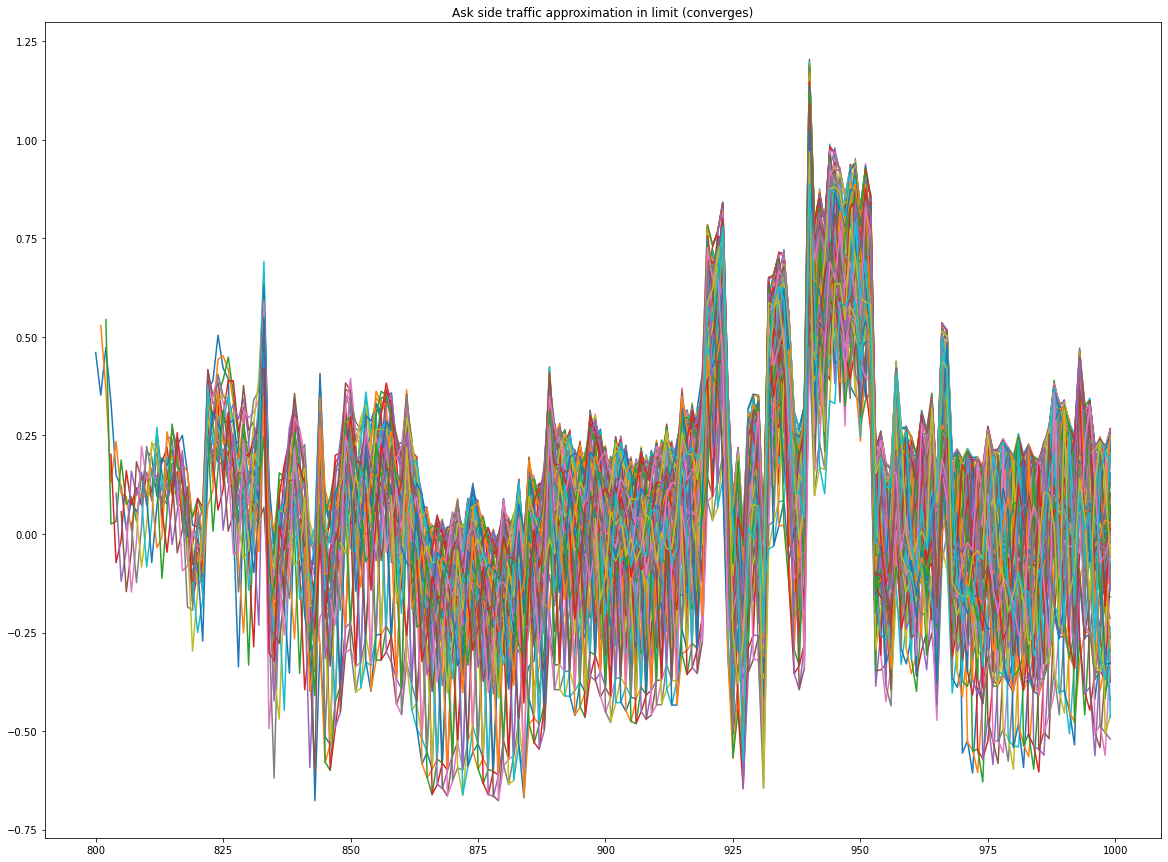

In [136]:
plt.figure(figsize=(20,15))
for i in range(600,700):
    plt.plot(HeavyTrafficApproximation(asks_amounts[200:1000], bids_amounts[200:1000], t=i)[0])

plt.title('Ask side traffic approximation in limit (converges)')
plt.show()

4) Orders arrival intervals (DataFrames and Series)

Показывает временные промежутки между приходами заявок. Скорее вспомогательная фича, нужная для следующей.

In [137]:
def OrderIntervals(amounts, time, method = 'datetime'):
    if method == 'datetime':
        differences = time.diff().astype('timedelta64[ns]')
        
        try:
            isdifferent = (amounts != amounts.shift(1)).sum(axis=1) > 0
        except:
            isdifferent = (amounts != amounts.shift(1))
            
        differences[isdifferent] = pd.Timedelta('0ns')
        
        for i in range(min(differences.index), max(differences.index)+1):
            if differences[i] != pd.Timedelta('0ns'):
                differences[i] += differences[i-1]
                
        differences[isdifferent] = time.diff().astype('timedelta64[ns]')[isdifferent]
        
    return differences/pd.Timedelta(seconds=1)

In [138]:
intervals = OrderIntervals(book['bids[0].amount'][100:1000], time[100:1000])

In [139]:
fig = px.scatter(y=intervals, x = time[100:1000], labels = ['intervals'], title = 'Interarrival time of bids orders in level 0')
    
fig.show()

5) Measure of intensity: larger lambda -> more intensive. lambda = N_arrivals / Sum(arrival intervals)

Показывает интенсивность прихода заявок за предыдущие window заявок. Из высокой интенсивности на одной стороне можно судить о том, куда может пойти цена в будущем.

In [140]:
def extractlambda(amounts, time, window=1000):
    obi = OrderIntervals(amounts, time)
    
    seq = obi.rolling(window).mean()
    seq.fillna(method='ffill', inplace = True)
    
    lamdba = 1/seq
    lamdba[lamdba == np.inf] = np.nan
    lamdba[lamdba == -np.inf] = np.nan
    
    return lamdba

In [141]:
lamdba = extractlambda(book['bids[0].amount'][10000:20000], time[10000:20000])

In [173]:
fig = px.line(y=lamdba, x = time[10000:20000], title = 'Intensity of orderflow')

fig.show()

6) Correlation of events in ask side and bid side of LOB

Показывает корреляцию изменния количества заявок на стороне бида и аска. С помощью нее можно понимать, является ли значимым увеличение заявок на стороне аска или бида.

In [143]:
def corr_OF(asks_amounts, bids_amounts, window=100, return_vars = False):
    Va, Vb = OrderFlow(asks_amounts, bids_amounts)
    
    ask = Va.sum(axis=1)
    bid = Vb.sum(axis=1)
    
    p = ask.rolling(window).corr(bid)
    
    if return_vars:
        return p, ask.rolling(window).std(), bid.rolling(window).std()
    
    return p

In [144]:
corrof = corr_OF(asks_amounts[:2000], bids_amounts[:2000])

In [174]:
fig = px.line(y=corrof, x = time[:2000], title = 'Correlation of ask and bid sides of orderflow')

fig.show()

7) Spitzer tail

Индекс хвоста времени распределения времени прихода заявки в зависимости от количества ордеров на стороне аск и бид.

In [146]:
def Spitzer_tail(asks_amounts, bids_amounts, window=100):
    p = corr_OF(asks_amounts, bids_amounts, window)
    
    return np.pi/(np.pi+2*np.arcsin(p))

In [147]:
spitzer = Spitzer_tail(asks_amounts[:2000], bids_amounts[:2000])

In [175]:
fig = px.line(y=spitzer, x = time[:2000], title = 'Spitzer tail')

fig.show()

8) Probability of next tick price to increase. General case.

Вероятность следующего тика быть больше чем предыдущий, если известна корреляция между ордерфлоу аска и бида. В общем случае.

In [149]:
def P_up(asks_amounts, bids_amounts, time, window=100, window_lambda=1000):
    p, va, vb = corr_OF(asks_amounts, bids_amounts, window, return_vars=True)
    lambda_a = extractlambda(asks_amounts, time, window_lambda)
    lambda_b = extractlambda(bids_amounts, time, window_lambda)
    
    ask = asks_amounts.sum(axis=1)
    bid = bids_amounts.sum(axis=1)
    
    y = ask/(lambda_a**0.5)/va
    x = bid/(lambda_b**0.5)/vb
    
    num = np.arctan(((1+p)/(1-p))**0.5 * (y-x)/(y+x))
    den = 2 * np.arctan(((1+p)/(1-p))**0.5)
    
    return 1/2 - num/den

In [165]:
pup = P_up(asks_amounts[:10000], bids_amounts[:10000], time[:10000])

fig = px.line(y=pup[5000:5300], x = time[5000:5300], title = 'Probability of next tick price to increase')

fig.show()

9) Expecancy of next tick price, if corr_OF=-1

Ожидаемое значение следующего тика, если известно, что корреляция = -1. Часто используется.

In [151]:
def Burghardt(asks_amounts, bids_amounts, ask_lowest_price, bid_highest_price):
    try:
        if asks_amounts.shape[1] != 0:
            share_a = asks_amounts.sum(axis=1)/(asks_amounts.sum(axis=1) + bids_amounts.sum(axis=1))
            share_b = bids_amounts.sum(axis=1)/(asks_amounts.sum(axis=1) + bids_amounts.sum(axis=1))
    except:
        share_a = asks_amounts/(asks_amounts+ bids_amounts)
        share_b = bids_amounts/(asks_amounts+ bids_amounts)
        
    P = share_a*ask_lowest_price + share_b*bid_highest_price
    
    return P

In [152]:
burghardt = Burghardt(asks_amounts, bids_amounts, ask_lowest_price, bid_highest_price)

fig = px.line(y=burghardt[:1000], x = time[:1000], title = 'Expecancy of next tick price, if corr_OF = -1')
fig.show()

10) Total LOB volume

Общее количество ордеров. Показывает, насколько большой рынок в данный момент.

In [153]:
def Volume(asks_amounts, bids_amounts):
    
    return asks_amounts.sum(axis=1), bids_amounts.sum(axis=1)

In [176]:
vol = pd.concat(Volume(asks_amounts[:10000], bids_amounts[:10000]), axis=1).rolling(1000).mean()#, columns=['ask volume', 'bid volume'])
vol.rename(columns = {0:'ask volume', 1:'bid volume'}, inplace=True)

fig = px.line(vol, y=['ask volume', 'bid volume'], x = time[:10000], title = 'Volume')
fig.show()

11) Spreads

Показывает спред в каждый момент времени, в целом он всегда около 0.1.

In [155]:
def Spread(asks_prices, bids_prices):
    
    return asks_prices[asks_prices.columns[0]] - bids_prices[bids_prices.columns[0]]

In [172]:
# spread = Spread(asks_prices, bids_prices)

# fig = px.line(y=spread[:10000].rolling(1000).mean(), x = time[:10000], title = 'Spread')
# fig.show()

12) Liquidity at best price

Показывает ликвидность при лучшей цене. Может выступать показателем устойчивости цены в данный момент.

In [157]:
def BestPriceLiquidity(asks_amounts, bids_amounts):
    
    return asks_amounts[asks_amounts.columns[0]], bids_amounts[bids_amounts.columns[0]]

In [168]:
liquidity = pd.concat(BestPriceLiquidity(asks_amounts, bids_amounts), axis=1).rolling(1000).mean()

fig = px.line(liquidity[:10000], y=['asks[0].amount', 'bids[0].amount'], x = time[:10000], title = 'Liquidity')
fig.show()

13) Share of orders on each level of LOB

Показывает распределение оъемов ордеров по стакану, то есть можно знать, на каком уровне наибольшая часть ордеров находится.

In [159]:
def LOBdistribution(asks_amounts, bids_amounts):
    total_a, total_b = Volume(asks_amounts, bids_amounts)
    
    dict_a = {}
    for i, name in enumerate(asks_amounts.columns):
        dict_a[name] = 'ask share lvl '+str(i)
        
    dict_b = {}
    for i, name in enumerate(bids_amounts.columns):
        dict_b[name] = 'bid share lvl '+str(i)
        
    ask = asks_amounts.divide(total_a,  axis=0).rename(columns = dict_a)
    bid = bids_amounts.divide(total_b,  axis=0).rename(columns = dict_b)
    
    return ask, bid

In [160]:
LOBdistribution(asks_amounts, bids_amounts)[1]

bid share lvl 0  bid share lvl 1  bid share lvl 2  bid share lvl 3  \
0              0.001923         0.005769         0.003846         0.003846   
1              0.001723         0.001723         0.001723         0.017227   
2              0.086737         0.032552         0.001213         0.007279   
3              0.000372         0.027506         0.087969         0.051666   
4              0.007316         0.033447         0.018291         0.048079   
...                 ...              ...              ...              ...   
640342         0.169262         0.002708         0.000339         0.010494   
640343         0.352690         0.002131         0.000266         0.008258   
640344         0.506863         0.001615         0.000202         0.006258   
640345         0.372791         0.001219         0.000152         0.004723   
640346         0.374966         0.002163         0.000270         0.008381   

        bid share lvl 4  bid share lvl 5  bid share lvl 6  bid share lvl 7  \
0              0.003846         0.038462         0.001923         0.001923   
1              0.000861         0.000861         0.000861         0.001723   
2              0.000404         0.009907         0.000202         0.001617   
3              0.069880         0.000496         0.138149         0.000124   
4              0.184217         0.062712         0.013065         0.001045   
...                 ...              ...              ...              ...   
640342         0.000677         0.054502         0.002708         0.083277   
640343         0.000533         0.042888         0.002131         0.065530   
640344         0.000404         0.032499         0.001615         0.049657   
640345         0.000305         0.024528         0.001219         0.037477   
640346         0.000541         0.043525         0.002163         0.143552   

        bid share lvl 8  bid share lvl 9  ...  bid share lvl 15  \
0              0.001923         0.003846  ...          0.317308   
1              0.000861         0.000861  ...          0.009475   
2              0.002022         0.008896  ...          0.114032   
3              0.097881         0.000620  ...          0.000124   
4              0.028743         0.000261  ...          0.012542   
...                 ...              ...  ...               ...   
640342         0.236967         0.000677  ...          0.000339   
640343         0.186468         0.000533  ...          0.000266   
640344         0.141300         0.000404  ...          0.000202   
640345         0.106642         0.000305  ...          0.000152   
640346         0.000541         0.156258  ...          0.000270   

        bid share lvl 16  bid share lvl 17  bid share lvl 18  \
0               0.001923          0.021154          0.003846   
1               0.001723          0.033592          0.611542   
2               0.001820          0.224424          0.000202   
3               0.001363          0.006443          0.000124   
4               0.001829          0.002874          0.013588   
...                  ...               ...               ...   
640342          0.000339          0.002370          0.007786   
640343          0.000266          0.000266          0.001332   
640344          0.000202          0.000202          0.001009   
640345          0.000152          0.003504          0.000305   
640346          0.006218          0.000541          0.044066   

        bid share lvl 19  bid share lvl 20  bid share lvl 21  \
0               0.075000          0.001923          0.405769   
1               0.181740          0.005168          0.031008   
2               0.158714          0.000607          0.010514   
3               0.247925          0.003345          0.140131   
4               0.000261          0.000261          0.007055   
...                  ...               ...               ...   
640342          0.015234          0.055179          0.000677   
640343          0.011987          0.043420      

# Data preprocessing

In [41]:
# import hftlib
from hftlib import TechnicalFeatures as tech
from hftlib import QuantitativeFeatures as quant
from hftlib import ContMaglaras as cont

### Cont

In [42]:
L = pd.DataFrame(index = book.index)
y = target

In [43]:
#1 lob second level generation
LOBsecondRand = cont.LOBSecondLevelRand(book['asks[1].amount'], book['bids[1].amount'])
L['Ask 1 lvl random'] = LOBsecondRand['asks[1].amount']
L['Bid 1 lvl random'] = LOBsecondRand['bids[1].amount']


#2 orderflow
orderflow = cont.OrderFlow(asks_amounts, bids_amounts)
orderflowask = orderflow[0]
orderflowbid = orderflow[1]
L = pd.concat([L, orderflowask, orderflowbid], axis=1)

orderflowtotal = cont.OrderFlow(asks_amounts, bids_amounts, total=True)
L['ask orderflow'] = orderflowtotal[0]
L['bid orderflow'] = orderflowtotal[1]



#3 heavy traffic approximation
heavytraffic = cont.HeavyTrafficApproximation(asks_amounts, bids_amounts)
L['heavytraffic ask'] = heavytraffic[0]
L['heavytraffic bid'] = heavytraffic[1]



#4 arrival intervals
intervals_ask = cont.OrderIntervals(asks_amounts, time)
intervals_bid = cont.OrderIntervals(bids_amounts, time)
L['intervals_ask'] = intervals_ask
L['intervals_bid'] = intervals_bid


#5 lambdas
lambda_ask = cont.extractlambda(asks_amounts, time)
lambda_bid = cont.extractlambda(bids_amounts, time)
L['lambda_ask'] = lambda_ask
L['lambda_bid'] = lambda_bid


#6 orderflow correlation
corrof = cont.corr_OF(asks_amounts, bids_amounts)
L['corr orderflow'] = corrof


#7 spitzer tail
spitzer = cont.Spitzer_tail(asks_amounts, bids_amounts)
L['spitzer'] = spitzer


#8 probability of next price to increase
pup = cont.P_up(asks_amounts, bids_amounts, time)
L['P up'] = pup


#9 probability, if correlation of orderflow = -1
burghardt = cont.Burghardt(asks_amounts, bids_amounts, ask_lowest_price, bid_highest_price)
L['burghardt'] = burghardt


#10 volume of orders
volume_a, volume_b = cont.Volume(asks_amounts, bids_amounts)
L['volume_ask'] = volume_a
L['volume_bid'] = volume_b


#11 spread
spread = cont.Spread(asks_prices, bids_prices)
L['spread'] = spread


#12 liquidity at best price
ask, bid = cont.BestPriceLiquidity(asks_amounts, bids_amounts)
L['liquidity ask'] = ask
L['liquidity bid'] = bid


#13 LOB distribution
one, two = cont.LOBdistribution(asks_amounts, bids_amounts)
L = pd.concat([L, one, two], axis=1)

In [44]:
L.tail()

Ask 1 lvl random  Bid 1 lvl random  ask 0 change  ask 1 change  \
640342             0.003             0.058         0.280        -0.003   
640343             0.003             0.060         0.500         0.000   
640344             0.003             0.060        -2.492         0.000   
640345             0.004             0.060        -0.576         0.000   
640346             0.004             0.060        -0.035         0.000   

        ask 2 change  ask 3 change  ask 4 change  ask 5 change  ask 6 change  \
640342        -0.001        -0.017         1.119         2.613         0.089   
640343         0.000         0.000         0.000        -0.158        -0.001   
640344        -0.362         0.343        -1.099        -2.455        -0.088   
640345         0.000        -0.342         0.342         0.008         0.000   
640346         0.000         0.000         0.000         0.000         0.000   

        ask 7 change  ...  bid share lvl 15  bid share lvl 16  \
640342        -0.144  ...          0.000339          0.000339   
640343         0.000  ...          0.000266          0.000266   
640344         1.216  ...          0.000202          0.000202   
640345         0.571  ...          0.000152          0.000152   
640346        -0.394  ...          0.000270          0.006218   

        bid share lvl 17  bid share lvl 18  bid share lvl 19  \
640342          0.002370          0.007786          0.015234   
640343          0.000266          0.001332          0.011987   
640344          0.000202          0.001009          0.000404   
640345          0.003504          0.000305          0.024832   
640346          0.000541          0.044066          0.000541   

        bid share lvl 20  bid share lvl 21  bid share lvl 22  \
640342          0.055179          0.000677          0.034529   
640343          0.043420          0.000533          0.027171   
640344          0.032903          0.000404          0.020589   
640345          0.000305          0.049817          0.001219   
640346          0.088402          0.002163          0.005948   

        bid share lvl 23  bid share lvl 24  
640342          0.002708          0.007448  
640343          0.002131          0.005860  
640344          0.001615          0.042390  
640345          0.031993          0.218007  
640346          0.116518          0.000270  

[5 rows x 119 columns]

### Tech

In [45]:
price = trades['price']
amount = trades['amount']

U = pd.DataFrame(index = price.index)

In [46]:
#1) ADL
U['ADL'] = tech.ADL(price, amount)

#2) ADX
U['ADX'] = tech.ADX(price)

#3) CMO
U['CMO'] = tech.CMO(price)

#4) Momentum
U['Momentum'] = tech.Momentum(price)

#5) ROC
U['ROC'] = tech.ROC(price)

#6) RSI
U['RSI'] = tech.RSI(price)

#7) Stochastic RSI
U['StochRSI'] = tech.StochasticRSI(price)

#8) Linear regression line
b0, b1 = tech.LinearRegressionLine(price)
U['b0 linreg'] = b0
U['b1 linreg'] = b1

#9) Realized Volatility
U['Volatlity'] = tech.RealizedVolatility(price)

#10) Realized Kernel
U['Kernel'] = tech.RealizedKernel(price)

#11) Realized Bipower Variation
U['Realized Bipower Variation'] = tech.RealizedBipowerVariation(price)

#12) Jump variation
U['Jump variation'] = tech.JumpVariation(price)

#13) Past returns
U['Past returns'] = tech.PastReturns(price)

#14) Awesome oscillator
U['Awesome oscillator'] = tech.AwesomeOscillator(price)

#15) ADXR
U['ADXR'] = tech.ADXR(price)

#16) Absolute price oscillator
U['APO'] = tech.APO(price)

#17) Average True Range
U['ATR'] = tech.ATR(price)

#18) Bollinger Bands
U['Bollinger mid'], U['Bollinger up'] ,U['Bollinger low'] = tech.Bollinger(price)

#19) ChaikinOscillator
U['CO'] = tech.ChaikinOscillator(price, amount)

#20) Chandelier Exit
U['ChandelierLong'], U['ChandelierShort'] = tech.ChandelierExit(price)

#21) Center of gravity
U['COG'] = tech.COG(price)

#22) Double exponential moving average
U['DEMA'] = tech.DEMA(price)

#23) Detrended price oscillator
U['DPO'] = tech.DPO(price)

#24) Weighted Moving Average
U['WMA'] = tech.WMA(price)

#25) Hull Moving Average
U['HMA'] = tech.HullMA(price)

#26) Internal bar strength
U['IBS'] = tech.IBS(price)

#27) Percentage price oscillator
U['PPO'] = tech.PPO(price)

#28) Autocorrelation
for i in range(1, 11):
    U[f'autocorrelation {i} lag'] = quant.Autocorrelation(price, window=100, lag=i)
    
#29)Partial Correlation
partial = quant.PartialCorrelation(price)
U = pd.concat([U, partial], axis=1)

In [47]:
U.tail()

ADL         ADX        CMO  Momentum       ROC        RSI  \
2054886 -1187.977056  215.418699 -24.528302       0.0 -0.006559  34.302326   
2054887 -1188.104856  215.418699 -24.921136       0.0 -0.006195  34.502924   
2054888 -1188.226956  215.418699 -27.439024      -1.2 -0.010932  32.608696   
2054889 -1188.336656  215.418699 -27.659574      -0.1 -0.011297  32.960894   
2054890 -1188.449256  215.418699 -28.048780       0.0 -0.010932  34.302326   

         StochRSI    b0 linreg  b1 linreg  Volatlity  ...  PACF for lag 1  \
2054886  0.288751  7528.938633   0.725624     0.1322  ...        0.983626   
2054887  0.290048  8848.084733   0.677546     0.1321  ...        0.983714   
2054888  0.277804  6128.687991   0.776647     0.1461  ...        0.981959   
2054889  0.280081  3640.913643   0.867309     0.1461  ...        0.981780   
2054890  0.288751  3640.913643   0.867309     0.1397  ...        0.982488   

         PACF for lag 2  PACF for lag 3  PACF for lag 4  PACF for lag 5  \
2054886        0.991781        0.437180        0.224171        0.354407   
2054887        0.992232        0.436752        0.228642        0.354719   
2054888        0.993111        0.428079        0.211711        0.340863   
2054889        0.993465        0.396960        0.185172        0.305783   
2054890        0.993351        0.399993        0.192472        0.311188   

         PACF for lag 6  PACF for lag 7  PACF for lag 8  PACF for lag 9  \
2054886        0.161558        0.108554        0.133791        0.068738   
2054887        0.153147        0.106126        0.141890        0.086222   
2054888        0.158040        0.120490        0.136151        0.059234   
2054889        0.133834        0.129044        0.149654        0.046847   
2054890        0.138364        0.130018        0.147345        0.044768   

         PACF for lag 10  
2054886         0.005568  
2054887         0.022335  
2054888        -0.025800  
2054889        -0.056069  
2054890        -0.053986  

[5 rows x 51 columns]

### Quant

In [48]:
V = pd.DataFrame(index = book.index)

In [49]:
#1) Order book imbalance
V['OBI'] = quant.OBI(asks_amounts, bids_amounts)

#2) Cointegration
V['Cointegration b0'], V['Cointegration b1'] = quant.Cointegration(asks_amounts, bids_amounts)

#3) Internal_imbalance_median_ask
V['Imbalance in ask'] = quant.Internal_imbalance_median_ask(asks_amounts, asks_prices)

#4) Internal_imbalance_median_bid
V['Imbalance in bid'] = quant.Internal_imbalance_median_bid(bids_amounts, bids_prices)

#5) Trade flow imbalance
V['TFI'] = quant.TFI(asks_amounts, bids_amounts)

In [50]:
V.tail()

OBI  Cointegration b0  Cointegration b1  Imbalance in ask  \
640342 -0.630126         16.019376         -0.798082           -9800.0   
640343 -0.580043         17.434824         -1.003215           -9630.0   
640344 -0.382294         17.703519         -1.074231           -9870.0   
640345 -0.252179         18.405555         -1.193341           -9870.0   
640346 -0.483019         15.520711         -0.763016           -9870.0   

        Imbalance in bid     TFI  
640342      4.445455e+05 -10.065  
640343      1.240000e+06 -10.370  
640344      1.240000e+06  -6.132  
640345      1.240000e+06  -4.427  
640346      1.240000e+06  -6.912

#### Concating all

In [51]:
V['local_ts'] = book['timestamp']
U['local_ts'] = trades['local_ts']
L['local_ts'] = book['timestamp']

In [59]:
#if needed
V = V[V['local_ts'] > V['local_ts'].shift(1)]

In [53]:
#if needed
U = U[U['local_ts'] > U['local_ts'].shift(1)]

In [64]:
#if needed
L = L[L['local_ts'] > L['local_ts'].shift(1)]

In [60]:
#1) Tech + Quant

V['local_ts'] = book['local_timestamp']
U['local_ts'] = trades['local_ts']

DF_lite = pd.merge_asof(left = U, right = V, direction='backward', on='local_ts')
DF_lite = pd.merge_asof(left = target, right = DF_lite, direction='backward', on='local_ts')
DF_lite.tail()

local_ts  target         ADL         ADX  \
3756553 2023-03-24 23:59:48.128667920       0 -1188.29865  215.418699   
3756554 2023-03-24 23:59:48.376390144       0 -1188.26985  215.418699   
3756555 2023-03-24 23:59:48.947874816       0 -1188.26985  215.418699   
3756556 2023-03-24 23:59:49.283046400       0 -1188.26985  215.418699   
3756557 2023-03-24 23:59:49.676728064       0 -1188.23115  215.418699   

               CMO  Momentum       ROC        RSI  StochRSI   b0 linreg  ...  \
3756553 -25.538462       0.3 -0.005831  28.977273  0.254332  -88.122569  ...   
3756554 -24.375000       0.0 -0.005831  28.977273  0.254332  514.038106  ...   
3756555 -24.375000       0.0 -0.005831  28.977273  0.254332  514.038106  ...   
3756556 -24.375000       0.0 -0.005831  28.977273  0.254332  514.038106  ...   
3756557 -24.137931       0.0 -0.005831  28.977273  0.254332  943.043463  ...   

         PACF for lag 7  PACF for lag 8  PACF for lag 9  PACF for lag 10  \
3756553        0.124431        0.136041        0.057627        -0.005658   
3756554        0.096585        0.102025        0.040982        -0.018140   
3756555        0.096585        0.102025        0.040982        -0.018140   
3756556        0.096585        0.102025        0.040982        -0.018140   
3756557        0.074338        0.087160        0.022739        -0.025362   

              OBI  Cointegration b0  Cointegration b1  Imbalance in ask  \
3756553 -0.027531          5.288051          0.210011           -9910.0   
3756554 -0.027531          5.288051          0.210011           -9910.0   
3756555 -0.027531          5.288051          0.210011           -9910.0   
3756556 -0.027531          5.288051          0.210011           -9910.0   
3756557  0.363497          6.808158         -0.063134           -9910.0   

         Imbalance in bid    TFI  
3756553     116582.278481 -0.375  
3756554     116582.278481 -0.375  
3756555     116582.278481 -0.375  
3756556     116582.278481 -0.375  
3756557     162413.793103  7.118  

[5 rows x 59 columns]

In [65]:
#2) Tech + Quant + Cont

L['local_ts'] = book['local_timestamp']

DF_full = pd.merge_asof(left = DF_lite, right = L, direction='backward', on='local_ts')
DF_full.tail()

local_ts  target         ADL         ADX  \
3756553 2023-03-24 23:59:48.128667920       0 -1188.29865  215.418699   
3756554 2023-03-24 23:59:48.376390144       0 -1188.26985  215.418699   
3756555 2023-03-24 23:59:48.947874816       0 -1188.26985  215.418699   
3756556 2023-03-24 23:59:49.283046400       0 -1188.26985  215.418699   
3756557 2023-03-24 23:59:49.676728064       0 -1188.23115  215.418699   

               CMO  Momentum       ROC        RSI  StochRSI   b0 linreg  ...  \
3756553 -25.538462       0.3 -0.005831  28.977273  0.254332  -88.122569  ...   
3756554 -24.375000       0.0 -0.005831  28.977273  0.254332  514.038106  ...   
3756555 -24.375000       0.0 -0.005831  28.977273  0.254332  514.038106  ...   
3756556 -24.375000       0.0 -0.005831  28.977273  0.254332  514.038106  ...   
3756557 -24.137931       0.0 -0.005831  28.977273  0.254332  943.043463  ...   

         bid share lvl 15  bid share lvl 16  bid share lvl 17  \
3756553          0.057225          0.000151          0.000302   
3756554          0.067385          0.000063          0.044374   
3756555          0.000373          0.043530          0.024374   
3756556          0.000373          0.043530          0.024374   
3756557          0.000375          0.043745          0.024494   

         bid share lvl 18  bid share lvl 19  bid share lvl 20  \
3756553          0.025970          0.000151          0.000151   
3756554          0.000063          0.000190          0.026181   
3756555          0.068724          0.027132          0.052177   
3756556          0.068724          0.027132          0.052177   
3756557          0.096255          0.000075          0.052434   

         bid share lvl 21  bid share lvl 22  bid share lvl 23  \
3756553          0.018723          0.065076          0.011928   
3756554          0.001585          0.001141          0.065737   
3756555          0.000149          0.052177          0.000075   
3756556          0.000149          0.052177          0.000075   
3756557          0.000150          0.052434          0.000150   

         bid share lvl 24  
3756553          0.064170  
3756554          0.000063  
3756555          0.000224  
3756556          0.000224  
3756557          0.000225  

[5 rows x 178 columns]

In [66]:
DF_full.shape

(3756558, 178)

# Model training

In [67]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [68]:
from catboost import CatBoostClassifier

### Метрика

In [75]:
from sklearn.metrics import confusion_matrix

def metric(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    weight_matrix = np.array([
        [1.9,     0,    -2],
        [-0.3,    0,    -0.3],
        [-2,      0,     1.9]
    ])
    
    hit_matrix = conf_matrix * weight_matrix
    hit_matrix_sum = np.sum(hit_matrix)
    action_count = np.sum(conf_matrix[:, 0]) + np.sum(conf_matrix[:, 2])
    if action_count == 0:
        return 0
    else:
        return hit_matrix_sum / np.sqrt(action_count)

### Lite

In [71]:
first_day = DF_lite['local_ts'] < '2023-03-23 00:00:00'
second_and_third_days = DF_lite['local_ts'] >= '2023-03-23 00:00:00'

In [70]:
X.shape

(3756558, 57)

In [69]:
X = DF_lite.drop(columns = ['local_ts', 'target'])
y = DF_lite['target']

In [72]:
X_train = X[first_day]
y_train = y[first_day]

X_test = X[second_and_third_days]
y_test = y[second_and_third_days]

In [105]:
catboost = CatBoostClassifier(depth=8)
catboost.fit(X_train, y_train)

Learning rate set to 0.115095
0:	learn: 1.0662095	total: 1.25s	remaining: 20m 46s
1:	learn: 1.0413319	total: 2.42s	remaining: 20m 8s
2:	learn: 1.0217672	total: 3.6s	remaining: 19m 55s
3:	learn: 1.0059906	total: 4.82s	remaining: 20m 1s
4:	learn: 0.9936033	total: 6.05s	remaining: 20m 4s
5:	learn: 0.9833102	total: 7.28s	remaining: 20m 5s
6:	learn: 0.9747598	total: 8.46s	remaining: 19m 59s
7:	learn: 0.9679645	total: 9.64s	remaining: 19m 55s
8:	learn: 0.9613761	total: 10.9s	remaining: 20m 2s
9:	learn: 0.9561667	total: 12.2s	remaining: 20m 5s
10:	learn: 0.9516680	total: 13.4s	remaining: 20m 6s
11:	learn: 0.9476033	total: 14.6s	remaining: 20m 4s
12:	learn: 0.9445076	total: 15.9s	remaining: 20m 4s
13:	learn: 0.9413451	total: 17s	remaining: 20m
14:	learn: 0.9386337	total: 18.2s	remaining: 19m 56s
15:	learn: 0.9358541	total: 19.4s	remaining: 19m 54s
16:	learn: 0.9334564	total: 20.7s	remaining: 19m 56s
17:	learn: 0.9311535	total: 21.9s	remaining: 19m 52s
18:	learn: 0.9292410	total: 23s	remaining:

In [106]:
preds = catboost.predict(X_test)

In [107]:
metric(y_test,preds)

-50.70992185780359

In [108]:
colors = ['orangered']*51 + ['lightgreen']*6

Text(0.5, 1.0, 'Feature Importance')

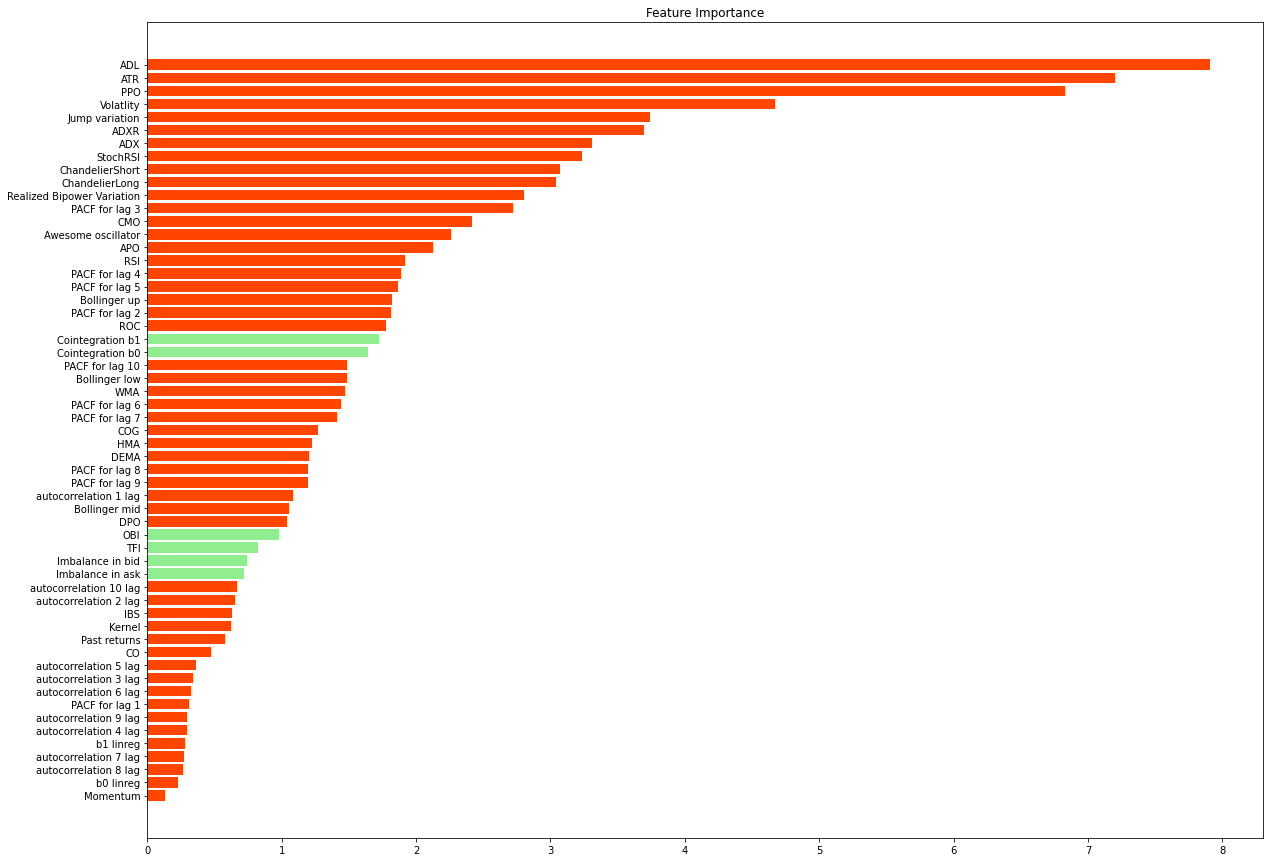

In [109]:
feature_importance = catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color = np.array(colors)[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Тут явно лидируют технические показатели по важности (оранжевые). Количественные - зеленые.

### Full

In [110]:
DF_full.head()

local_ts  target  ADL  ADX  CMO  Momentum  ROC  RSI  \
0 2023-03-22 00:00:00.002269696       0  NaN  NaN  NaN       NaN  NaN  NaN   
1 2023-03-22 00:00:00.048079360       0  NaN  NaN  NaN       NaN  NaN  NaN   
2 2023-03-22 00:00:00.057478144       0  NaN  NaN  NaN       NaN  NaN  NaN   
3 2023-03-22 00:00:05.344112384      -1  NaN  NaN  NaN      -0.2  NaN  NaN   
4 2023-03-22 00:00:06.436654848      -1  NaN  NaN  NaN      -0.2  NaN  NaN   

   StochRSI  b0 linreg  ...  bid share lvl 15  bid share lvl 16  \
0       NaN        NaN  ...               NaN               NaN   
1       NaN        NaN  ...               NaN               NaN   
2       NaN        NaN  ...               NaN               NaN   
3       NaN        NaN  ...               NaN               NaN   
4       NaN        NaN  ...               NaN               NaN   

   bid share lvl 17  bid share lvl 18  bid share lvl 19  bid share lvl 20  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   bid share lvl 21  bid share lvl 22  bid share lvl 23  bid share lvl 24  
0               NaN               NaN               NaN               NaN  
1               NaN               NaN               NaN               NaN  
2               NaN               NaN               NaN               NaN  
3               NaN               NaN               NaN               NaN  
4               NaN               NaN               NaN               NaN  

[5 rows x 178 columns]

In [111]:
X = DF_full.drop(columns = ['local_ts', 'target'])
y = DF_full['target']

X_train = X[first_day]
y_train = y[first_day]

X_test = X[second_and_third_days]
y_test = y[second_and_third_days]

In [112]:
X.shape

(3756558, 176)

In [113]:
catboost = CatBoostClassifier(depth=8)
catboost.fit(X_train, y_train)

Learning rate set to 0.115095
0:	learn: 1.0652996	total: 3.36s	remaining: 55m 54s
1:	learn: 1.0395003	total: 6.61s	remaining: 55m
2:	learn: 1.0195036	total: 9.86s	remaining: 54m 36s
3:	learn: 1.0032805	total: 13.1s	remaining: 54m 26s
4:	learn: 0.9898861	total: 16.4s	remaining: 54m 21s
5:	learn: 0.9788517	total: 19.7s	remaining: 54m 20s
6:	learn: 0.9693980	total: 23s	remaining: 54m 17s
7:	learn: 0.9614687	total: 26.2s	remaining: 54m 10s
8:	learn: 0.9551006	total: 29.5s	remaining: 54m 4s
9:	learn: 0.9491467	total: 32.7s	remaining: 54m
10:	learn: 0.9442427	total: 36s	remaining: 53m 54s
11:	learn: 0.9401676	total: 39.3s	remaining: 53m 52s
12:	learn: 0.9369079	total: 42.5s	remaining: 53m 47s
13:	learn: 0.9336600	total: 45.8s	remaining: 53m 43s
14:	learn: 0.9302002	total: 49s	remaining: 53m 40s
15:	learn: 0.9277246	total: 52.3s	remaining: 53m 36s
16:	learn: 0.9251650	total: 55.5s	remaining: 53m 32s
17:	learn: 0.9228922	total: 58.8s	remaining: 53m 29s
18:	learn: 0.9209043	total: 1m 2s	remaini

In [114]:
preds = catboost.predict(X_test)

In [115]:
metric(y_test, preds)

-1.2513887681818738

In [117]:
colors = ['orangered']*51 + ['lightgreen']*6 + ['royalblue'] * 119

Text(0.5, 1.0, 'Feature Importance')

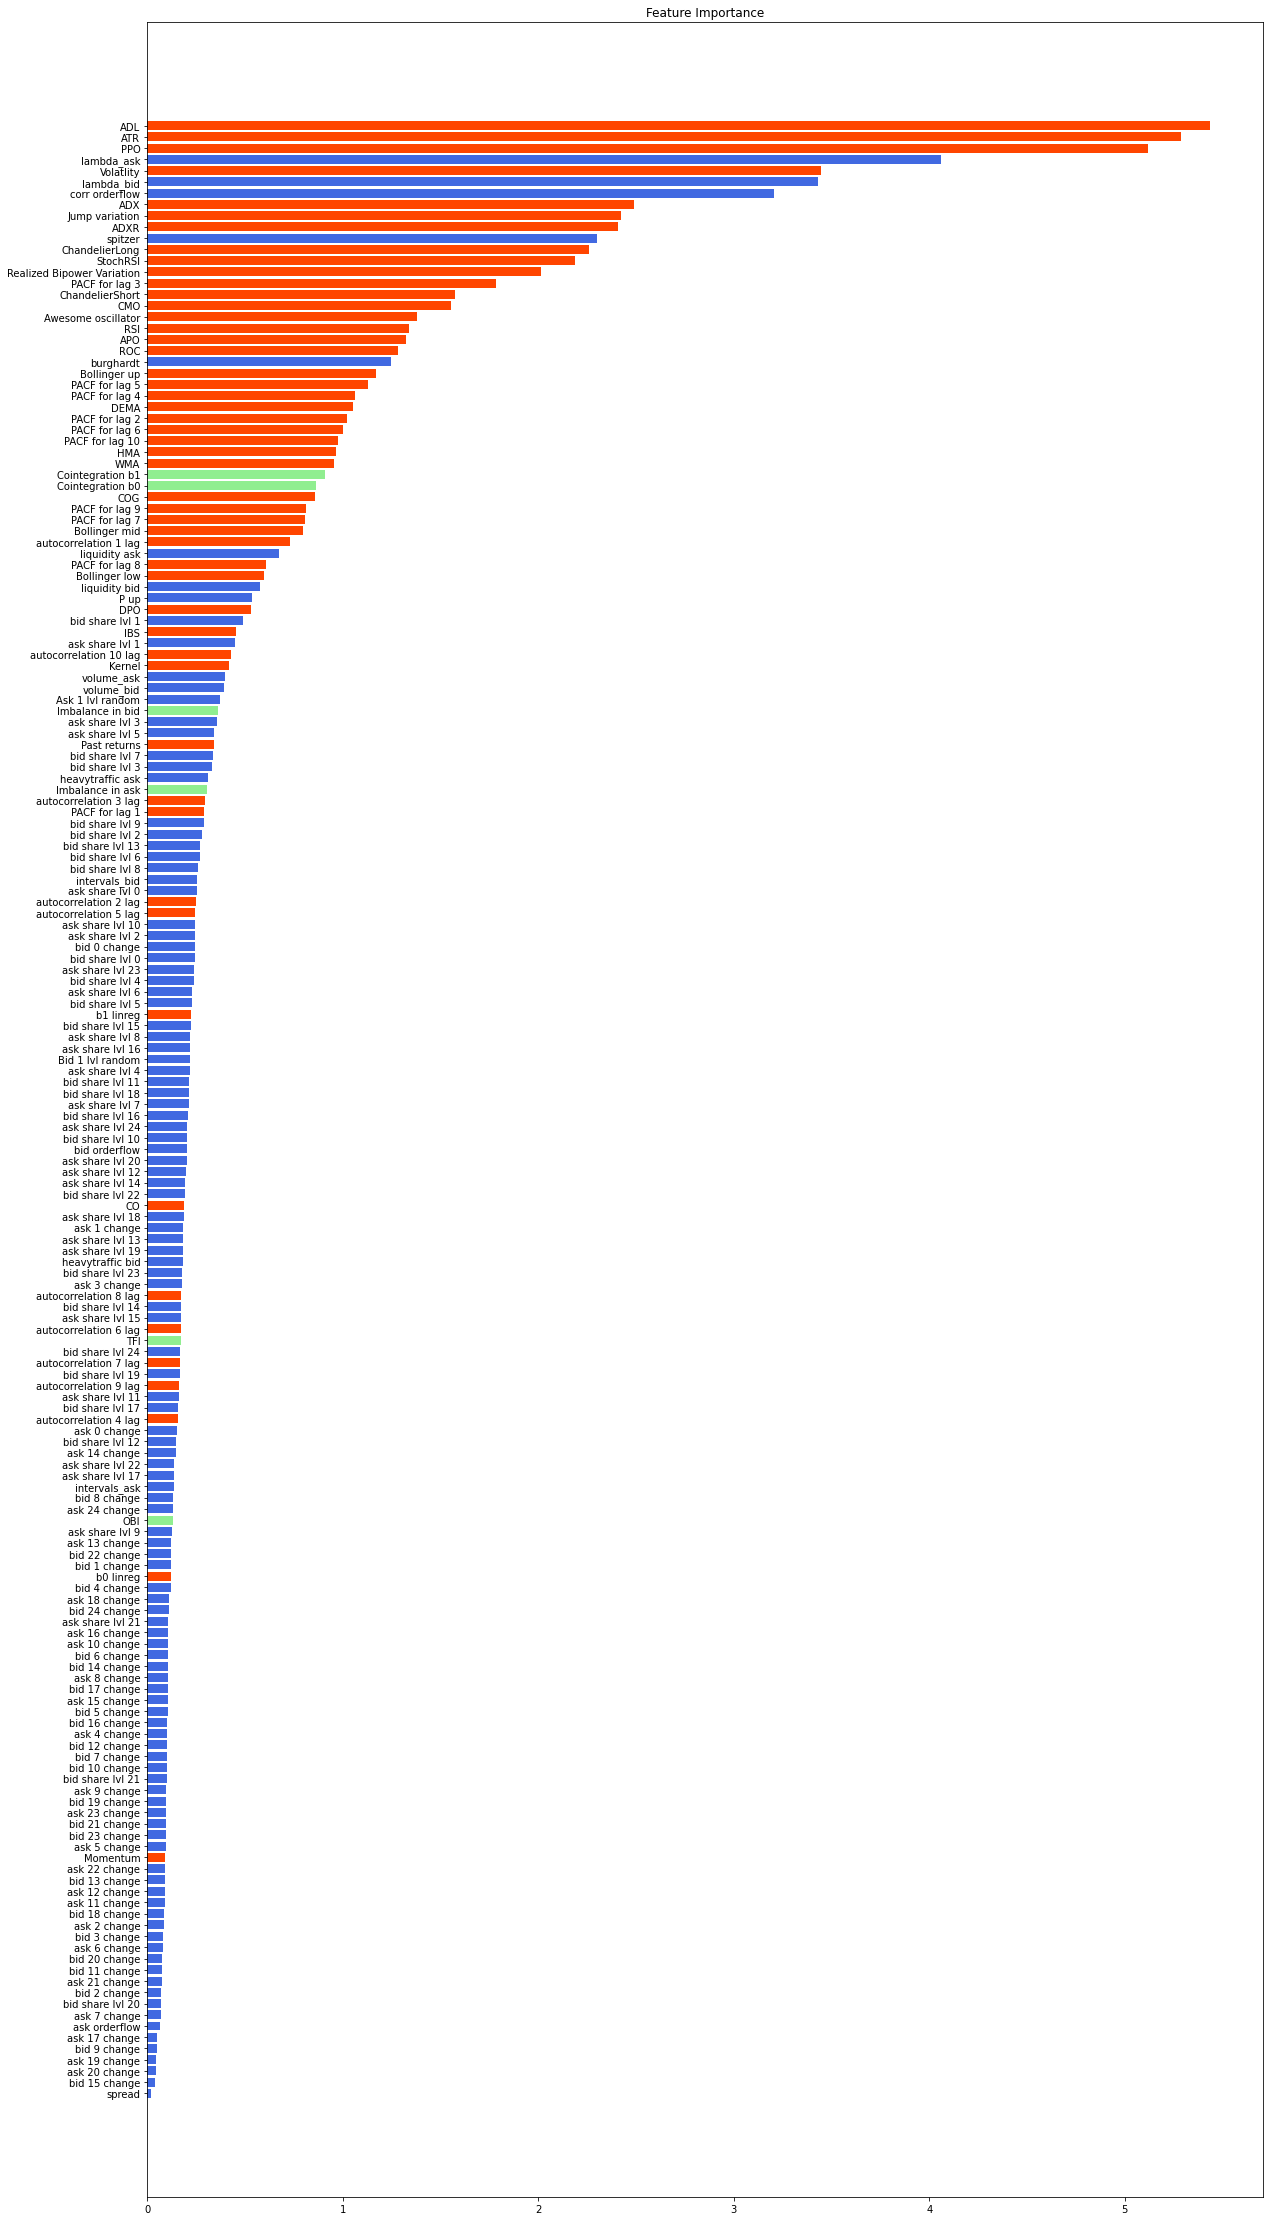

In [118]:
feature_importance = catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 40))

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color = np.array(colors)[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Хоть технические фичи до сих пор наверху (оранжевые), количественные так же не очень высоко (зеленые), но достаточно высоко оказались новые фичи, свзяанные с ордербуком (синие), особенно высоко оказались интенсивность аск флоу и бид флоу (лямбды), также высоко оказалась корреляция аск и бид флоу.

Метрика поднялась с -50 до -1.25 за 2 дня на одинаковом классификаторе.